# Evalation results of all models on s-MNIST dataset
the evaluation results of all modesl on testing examples

In [1]:
%reload_ext autoreload
%autoreload 2
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import os
import sys
root_path = os.path.dirname(os.getcwd())
sys.path.append(root_path)

from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import time
import copy
import glob
import re
import importlib
from PIL import Image

import cv2
from ndp.ndp_nets.dnn_ndp_main import NdpDNN
from ndp.ndp_nets.scnn_ndp_main import NdpSCNN
from ndp.ndp_nets.cnn_ndp_main import NdpCNN

plt.ion()   # interactive mode

In [2]:
def load_model(root_path, model_path):
    # Read network description file
    with open(os.path.join(root_path, model_path, 'network_description.txt')) as f:
        network_description_str = f.read()

    # Get the model class from the network description and dynamically import it
    model_module_class_str = re.search('Model: (.+?)\n', network_description_str).group(1)
    model_module_str = os.path.splitext(model_module_class_str)[0]
    model_class_str = os.path.splitext(model_module_class_str)[1][1:]
    model_module = importlib.import_module(model_module_str)
    model_class = getattr(model_module, model_class_str)

    # Get the pre-trained CNN model load path from the network description
    if model_class_str == 'CNNEncoderDecoderNet':
        pre_trained_cnn_model_path = os.path.join(root_path, re.search('Pre-trained CNN model load path: (.+?)\n', network_description_str).group(1))

    # Load layer sizes
    layer_sizes = np.load(os.path.join(model_path, 'layer_sizes.npy'), allow_pickle=True).tolist()

    # Load scaling
    try:
        scaling = Mapping()
        scaling.x_max = np.load(os.path.join(root_path, model_path, 'scale_x_max.npy'))
        scaling.x_min = np.load(os.path.join(root_path, model_path, 'scale_x_min.npy'))
        scaling.y_max = np.load(os.path.join(root_path, model_path, 'scale_y_max.npy'))
        scaling.y_min = np.load(os.path.join(root_path, model_path, 'scale_y_min.npy'))
    except:
        scaling = np.load(os.path.join(root_path, model_path, 'scale.npy'))

    # Load the model
    if model_class_str == 'CNNEncoderDecoderNet':
        model = model_class(pre_trained_cnn_model_path, layer_sizes, scaling)
    else:
        model = model_class(layer_sizes, None, scaling)
        
    # Load the model state parameters
    state = torch.load(os.path.join(root_path, model_path, 'net_parameters'), map_location=torch.device('cpu'))
    model.load_state_dict(state)
    
    return model

## 1, Load the trained Models(N=25, T=300) on SMNIST and Evaluation the Performance

### 1, DNN-DMP model

In [3]:
root_path = os.path.dirname(os.getcwd()) + '/imednet'
sys.path.append(root_path)
from imednet.trainers.encoder_decoder_trainer import Trainer
from imednet.data.nmnist_loader import NMNIST
from imednet.data.smnist_loader import MatLoader, Mapping

model_path = os.path.join(root_path, 'models/encoder_decoder/imednet-40x40-smnist 2021-07-29 22:01:38.504222/')
dnn_dmp_model = load_model(root_path, model_path)
model_stub = 'imednet_etoe_adam'
print(dnn_dmp_model)

No cuda library
EncoderDecoderNet(
  (input_layer): Linear(in_features=1600, out_features=1500, bias=True)
  (middle_layer_1): Linear(in_features=1500, out_features=1300, bias=True)
  (middle_layer_2): Linear(in_features=1300, out_features=1000, bias=True)
  (middle_layer_3): Linear(in_features=1000, out_features=600, bias=True)
  (middle_layer_4): Linear(in_features=600, out_features=200, bias=True)
  (middle_layer_5): Linear(in_features=200, out_features=20, bias=True)
  (middle_layer_6): Linear(in_features=20, out_features=35, bias=True)
  (output_layer): Linear(in_features=35, out_features=54, bias=True)
)


### 2, CNN-DMP model

In [4]:
root_path = os.path.dirname(os.getcwd()) + '/imednet'
sys.path.append(root_path)
model_path = os.path.join(root_path, 'models/cnn_encoder_decoder/cfcimednet-40x40-smnist-adam-end-to-end 2021-07-29 23:57:28.008853/')
cnn_dmp_model = load_model(root_path, model_path)
model_stub = 'cfcimednet_etoe_adam'
print(cnn_dmp_model)

CNNEncoderDecoderNet(
  (cnn_model): Sequential(
    (0): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
    (1): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  )
  (input_layer): Linear(in_features=20480, out_features=600, bias=True)
  (middle_layer_1): Linear(in_features=600, out_features=200, bias=True)
  (middle_layer_2): Linear(in_features=200, out_features=20, bias=True)
  (middle_layer_3): Linear(in_features=20, out_features=35, bias=True)
  (output_layer): Linear(in_features=35, out_features=54, bias=True)
)


### 3, DNN-NDP model

In [5]:
k = 1
T = 300 / k
N = 25
pre_trained = '../ndp/mnist_cnn/cnn_trained/mnist_dnn_net_500(mnist).pt'
dnn_ndp = NdpDNN(T=T, l=1, N=N, pt=pre_trained, state_index=np.arange(2))
path = '../ndp/ndp_models/dnn-ndp-il_(smnist)_(T300.0_K1_N25_L0.001_E150_B100)_(2021_07_30_14_53_18_898040)/dnn-model.pt'
dnn_ndp.load_state_dict(torch.load(path, map_location=torch.device('cpu')))
dnn_ndp.eval()

NdpDNN(
  (pt): DNNNet(
    (fc1): Linear(in_features=784, out_features=500, bias=True)
    (fc2): Linear(in_features=500, out_features=10, bias=True)
  )
  (middle_layer_1): Linear(in_features=500, out_features=100, bias=True)
  (middle_layer_2): Linear(in_features=100, out_features=500, bias=True)
  (middle_layer_3): Linear(in_features=500, out_features=108, bias=True)
  (middle_layer_4): Linear(in_features=108, out_features=54, bias=True)
  (last_fc): Linear(in_features=54, out_features=54, bias=True)
)

### 4, SCNN-NDP model

In [6]:
k = 1
T = 300 / k
N = 25
pre_trained = '../ndp/mnist_cnn/cnn_trained/mnist_cnn_net_simple_500(mnist).pt'
scnn_ndp = NdpSCNN(T=T, l=1, N=N, pt=pre_trained, state_index=np.arange(2))

path = '../ndp/ndp_models/scnn-ndp-il_(smnist)_(T300.0_K1_N25_L0.001_E150_B100)_(2021_07_30_14_53_08_397187)/scnn-model.pt'
scnn_ndp.load_state_dict(torch.load(path, map_location=torch.device('cpu')))
scnn_ndp.eval()

NdpSCNN(
  (pt): SimpleCNNNet(
    (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
    (fc1): Linear(in_features=2880, out_features=500, bias=True)
    (fc2): Linear(in_features=500, out_features=10, bias=True)
  )
  (middle_layer_1): Linear(in_features=500, out_features=100, bias=True)
  (middle_layer_2): Linear(in_features=100, out_features=500, bias=True)
  (middle_layer_3): Linear(in_features=500, out_features=108, bias=True)
  (middle_layer_4): Linear(in_features=108, out_features=54, bias=True)
  (last_fc): Linear(in_features=54, out_features=54, bias=True)
)

### 5, CNN-NDP model

In [7]:
k = 1
T = 300 / k
N = 25
pre_trained = '../ndp/mnist_cnn/cnn_trained/mnist_cnn_net_500(mnist).pt'
cnn_ndp = NdpCNN(T=T, l=1, N=N, pt=pre_trained, state_index=np.arange(2))

path = '../ndp/ndp_models/cnn-ndp-il_(smnist)_(T300.0_K1_N25_L0.001_E150_B100)_(2021_07_30_14_52_04_152442)/cnn-model.pt'
cnn_ndp.load_state_dict(torch.load(path, map_location=torch.device('cpu')))
cnn_ndp.eval()

NdpCNN(
  (pt): CNNNet(
    (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
    (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
    (fc1): Linear(in_features=800, out_features=500, bias=True)
    (fc2): Linear(in_features=500, out_features=10, bias=True)
  )
  (middle_layer_1): Linear(in_features=500, out_features=100, bias=True)
  (middle_layer_2): Linear(in_features=100, out_features=500, bias=True)
  (middle_layer_3): Linear(in_features=500, out_features=108, bias=True)
  (middle_layer_4): Linear(in_features=108, out_features=54, bias=True)
  (last_fc): Linear(in_features=54, out_features=54, bias=True)
)

In [8]:
# Synthetic MNIST (s-MNIST)
from imednet.data.smnist_loader import MatLoader, Mapping
data_path = '../../imednet/data/s-mnist/40x40-smnist.mat'
data_stub = 'smnist'
# load the snist image data
images, outputs, scale, or_tr = MatLoader.load_data(data_path,load_original_trajectories=True)

In [9]:
# transform the images from 40x40 to 28x28
images_resize = np.array([cv2.resize(img, (28, 28)) for img in images]) / 255.0
outputs_resize = np.array([cv2.resize(img, (28, 28)) for img in outputs]) / 255.0
input_size = images_resize.shape[1] * images_resize.shape[2]

# to torch tensor
X_test = torch.Tensor(images_resize).float()
Y_test = torch.Tensor(np.array(or_tr)[:, :, :2]).float()
O_test = torch.Tensor(outputs_resize).float()
print(X_test.shape)
print(Y_test.shape)
print(O_test.shape)

torch.Size([20000, 28, 28])
torch.Size([20000, 301, 2])
torch.Size([20000, 28, 28])


In [10]:
trainer = Trainer()
def fn_dmp_loss(trianed_model, test_inds):
    torch_images  = torch.autograd.Variable(torch.from_numpy(images[test_inds, :])).float()
    torch_outputs = torch.autograd.Variable(torch.from_numpy(outputs[test_inds, :])).float()
    torch_predicted_outputs = trianed_model(torch_images)

    loss_value = 0
    for i_sample in range(torch_predicted_outputs.shape[0]):
        sample_output_dmp = trainer.create_dmp(torch_outputs[i_sample,:], trianed_model.scale, 0.01, 25, True)
        sample_output_dmp.joint()

        torch_sample_predicted_output = torch.cat((torch.tensor([-1.]), torch_predicted_outputs[i_sample,:]), 0)
        sample_predicted_output_dmp = trainer.create_dmp(torch_sample_predicted_output, trianed_model.scale, 0.01, 25, True)
        sample_predicted_output_dmp.joint()
        test = ((sample_output_dmp.Y - sample_predicted_output_dmp.Y) ** 2).mean(1)
        loss_value = loss_value + test.mean().item()

    return loss_value/torch_predicted_outputs.shape[0]

In [11]:
test_sample = [50, 100, 200, 500, 1000, 2000]
data = []
for s in test_sample:
    test_inds = np.arange(int(s))
    np.random.shuffle(test_inds)
    x_test = X_test[test_inds]
    y_test = Y_test[test_inds]
    dnn_y_htest  = dnn_ndp(x_test,  y_test[:, 0, :])  # iamges, trajectories
    scnn_y_htest = scnn_ndp(x_test, y_test[:, 0, :])
    cnn_y_htest  = cnn_ndp(x_test,  y_test[:, 0, :])
    
    temp = []
    temp.append(str(s))
    
    # Get the DNN-DMP loss value on the test examples
    dnn_dmp_test = fn_dmp_loss(dnn_dmp_model, test_inds)
    temp.append(round(dnn_dmp_test, 3))
    
    # Get the CNN-DMP loss value on the test examples
    cnn_dmp_test = fn_dmp_loss(cnn_dmp_model, test_inds) 
    temp.append(round(cnn_dmp_test, 3))
        
    # Get the DNN-NDP loss value on the test examples
    dnn_test = ((dnn_y_htest - y_test) ** 2).mean(1).mean(1)
    temp.append(round(dnn_test.mean().item(), 3))
    
    # Get the SCNN-NDP loss value on the test examples
    scnn_test = ((scnn_y_htest - y_test) ** 2).mean(1).mean(1)
    temp.append(round(scnn_test.mean().item(), 3))
    
    # Get the CNN-NDP loss value on the test examples
    cnn_test = ((cnn_y_htest - y_test) ** 2).mean(1).mean(1)
    temp.append(round(cnn_test.mean().item(), 3))
    data.append(temp)


/Users/shengdaolin_sh/dir_install/Aanconda3/anaconda3/envs/env_msc_project_py38/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [12]:
data

[['50', 0.064, 0.091, 0.436, 0.546, 0.359],
 ['100', 0.064, 0.104, 0.452, 0.541, 0.386],
 ['200', 0.067, 0.105, 0.459, 0.563, 0.379],
 ['500', 0.066, 0.111, 0.472, 0.553, 0.382],
 ['1000', 0.07, 0.115, 0.477, 0.553, 0.374],
 ['2000', 0.066, 0.111, 0.472, 0.554, 0.376]]

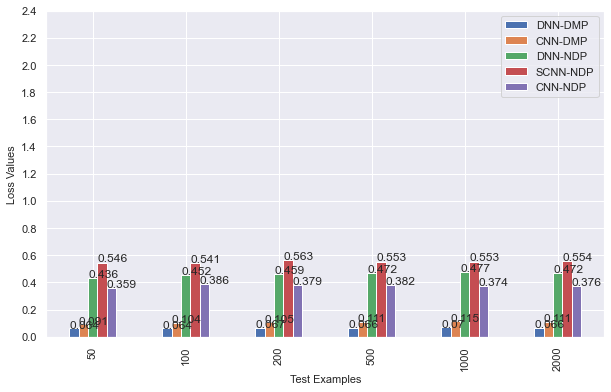

In [13]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
%matplotlib inline
sns.set_theme(style="darkgrid")
# sns.set_theme(style="whitegrid")

columns=["Test Examples", "DNN-DMP", "CNN-DMP", "DNN-NDP", "SCNN-NDP", "CNN-NDP"]
df=pd.DataFrame(data, columns=columns)
ax = df.plot(x="Test Examples", y=["DNN-DMP", "CNN-DMP", "DNN-NDP", "SCNN-NDP", "CNN-NDP"], kind="bar",figsize=(10,6))
plt.yticks(np.arange(0, 2.6, 0.2))
plt.xlabel('Test Examples', fontsize='11')
plt.ylabel('Loss Values', fontsize='11')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x(), p.get_height() * 1.01))
plt.show()

In [14]:
new_data = []
for i in range(1,6):
    temp = []
    for d in data:
        temp.append(d[i])
    new_data.append(temp)
print(new_data)

[[0.064, 0.064, 0.067, 0.066, 0.07, 0.066], [0.091, 0.104, 0.105, 0.111, 0.115, 0.111], [0.436, 0.452, 0.459, 0.472, 0.477, 0.472], [0.546, 0.541, 0.563, 0.553, 0.553, 0.554], [0.359, 0.386, 0.379, 0.382, 0.374, 0.376]]


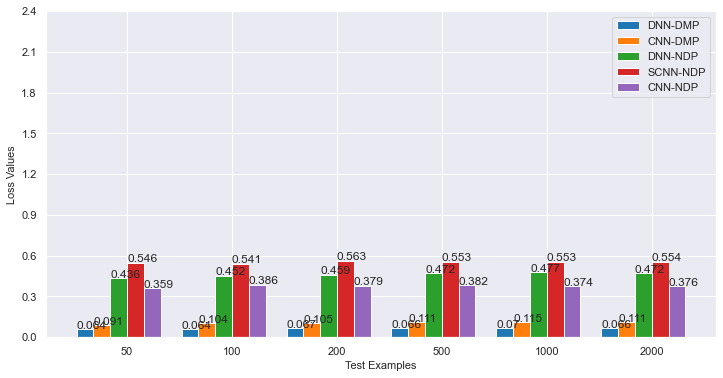

In [15]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
%matplotlib inline
from matplotlib.colors import ListedColormap
sns.set_theme(style="darkgrid")
# sns.set_theme(style="whitegrid")

plt.figure(figsize=(12,6))
N = 6
width = 0.16
ind = np.arange(N) 

sns.set_palette("tab10")
# sns.set_palette("hls")

plt.bar(ind-2*width, new_data[0], width, label='DNN-DMP')
plt.bar(ind-width, new_data[1], width, label='CNN-DMP')
plt.bar(ind, new_data[2], width, label='DNN-NDP')
plt.bar(ind+width, new_data[3], width, label='SCNN-NDP')
plt.bar(ind+width*2, new_data[4], width, label='CNN-NDP')

ax = plt.subplot()
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x(), p.get_height() * 1.01))
    
plt.ylabel('Loss Values', fontsize='11')
plt.xlabel('Test Examples', fontsize='11')
plt.yticks(np.arange(0, 2.6, 0.3))
plt.xticks(ind + width / 2, ('50', '100', '200', '500', '1000', '2000'))
plt.legend(loc='upper right')
plt.show()

## 2, Show the performance of Models on s-MNIST datasets

In [ ]:
def show_images(image, trajectory, dmp):
    C = None
    H, W = image.shape
    
    plt.figure()
    plt.imshow(image, cmap='gray', extent=[0, H+1, W+1, 0])
    plt.axis('off')
  
    plt.figure()
    plt.imshow(image, cmap='gray', extent=[0, H+1, W+1, 0]) 
    plt.plot(trajectory[:,0], trajectory[:,1],'-b', linewidth=3.0)
    plt.axis('off')
         
#   =================     
        
    plt.figure()
    plt.imshow(image, cmap='gray', extent=[0, H+1, W+1, 0])
    
    dmp.joint()
    plt.plot(dmp.Y[:,0], dmp.Y[:,1],'-r', linewidth=3.0)
    plt.axis('off')    
    
    plt.figure()
    plt.imshow(image, cmap='gray', extent=[0, H+1, W+1, 0]) 
    
    plt.plot(trajectory[:,0], trajectory[:,1],'-b', linewidth=3.0)

    dmp.joint()
    plt.plot(dmp.Y[:,0], dmp.Y[:,1],'-r', linewidth=3.0) 
    plt.axis('off')

In [ ]:
def show_image_for_NDP(model, test_sample_indices, digit):
    y_h = model(X_test[test_sample_indices], Y_test[test_sample_indices, 0, :])
    y_r = Y_test[test_sample_indices]
    
    plt.figure()
    image = images[test_sample_indices[digit]]
    H, W = image.shape
    plt.imshow(image, cmap='gray', extent=[0, H+1, W+1, 0])
    plt.axis('off')

    plt.figure()
    plt.imshow(image, cmap='gray', extent=[0, H+1, W+1, 0])
    plt.plot(y_r[digit, :, 0].detach().cpu().numpy(),y_r[digit, :, 1].detach().cpu().numpy(), c='b', linewidth=3)
    plt.axis('off')

    plt.figure()
    plt.imshow(image, cmap='gray', extent=[0, H+1, W+1, 0])
    plt.plot(y_h[digit, :, 0].detach().cpu().numpy(),y_h[digit, :, 1].detach().cpu().numpy(), c='r', linewidth=3)
    plt.axis('off')

    plt.figure()
    plt.imshow(image, cmap='gray', extent=[0, H+1, W+1, 0])
    plt.plot(y_h[digit, :, 0].detach().cpu().numpy(),y_h[digit, :, 1].detach().cpu().numpy(), c='r', linewidth=3)
    plt.plot(y_r[digit, :, 0].detach().cpu().numpy(),y_r[digit, :, 1].detach().cpu().numpy(), c='b', linewidth=3)
    plt.axis('off')

    plt.show()

In [ ]:
def show_image_for_DMP(model, test_sample_indices, digit):
    torch_images  = torch.autograd.Variable(torch.from_numpy(images[test_sample_indices, :])).float()
    torch_outputs = torch.autograd.Variable(torch.from_numpy(outputs[test_sample_indices, :])).float()
    torch_predicted_outputs = model(torch_images)
    sample_output_dmp = trainer.create_dmp(torch_outputs[digit,:], model.scale, 0.01, 25, True)
    sample_output_dmp.joint()
    torch_sample_predicted_output = torch.cat((torch.tensor([-1.]), torch_predicted_outputs[0,:]), 0)
    sample_predicted_output_dmp = trainer.create_dmp(torch_sample_predicted_output, model.scale, 0.01, 25, True)
    show_images(torch_images[digit,:], sample_output_dmp.Y, sample_predicted_output_dmp)

In [ ]:
test_samples = [[490, 740, 1100, 1330, 1800, 2700],
                [461, 521, 901, 1001, 1101, 1431, 2061, 2141],
                [322, 422, 1532, 1762, 1882, 2102, 2142, 2382, 2732],
                [333, 1023, 1623, 2823, 2963],
                [214, 284, 894, 954, 1244, 1254, 1754, 1954],
                [295, 1715, 1795, 2075, 2265],
                [146, 166, 456, 546, 746, 1016, 1276, 1956, 1976, 2646],
                [157, 487, 547, 577, 737, 727, 977, 1147, 2327, 1577, 1687],
                [988, 1418, 1678, 1818, 2578, 2648],
                [1629, 1969, 1999, 2019],
                [490, 901, 2732, 1623, 214, 1715, 1976, 977, 988, 1629]
               ]

In [ ]:
test_sample_indices = [490, 901, 2732, 1623, 214, 1715, 1976, 977, 988, 1629]
digit = 9
test_sample_indices1 = [test_sample_indices[digit]]

In [ ]:
# DNN-DMP model
show_image_for_DMP(dnn_dmp_model, test_sample_indices1, 0)

In [ ]:
# CNN-DMP model
show_image_for_DMP(cnn_dmp_model, test_sample_indices1, 0)

In [ ]:
# DNN-NDP model
show_image_for_NDP(dnn_ndp, test_sample_indices, digit)

In [ ]:
# SCNN-NDP model
show_image_for_NDP(scnn_ndp, test_sample_indices, digit)

In [ ]:
# CNN-NDP model
show_image_for_NDP(cnn_ndp, test_sample_indices, digit)

## 3, Show the performance of Models on m-MNIST datasets

In [110]:
def show_NDP_m_mnist(y_h, image):
    plt.figure()
    H, W = image.shape
    plt.imshow(image, cmap='gray', extent=[0, H+1, W+1, 0])
    plt.plot(y_h[i, :, 0].detach().cpu().numpy(),y_h[i, :, 1].detach().cpu().numpy(), c='r', linewidth=3)
    plt.axis('off')
    plt.show()

In [111]:
def show_DMP_images(image, dmp):
    C = None
    H, W = image.shape     
    plt.figure()
    plt.imshow(image, cmap='gray', extent=[0, H+1, W+1, 0])
    
    dmp.joint()
    plt.plot(dmp.Y[:,0], dmp.Y[:,1],'-r', linewidth=3.0)
    plt.axis('off')    

In [112]:
def show_DMP_m_mnist(model, torch_images, torch_predicted_outputs, i):
    torch_sample_predicted_output = torch.cat((torch.tensor([-1.]), torch_predicted_outputs[i,:]), 0)
    sample_predicted_output_dmp = trainer.create_dmp(torch_sample_predicted_output, model.scale, 0.001, 25, True)
    show_DMP_images(torch_images[i,:], sample_predicted_output_dmp)

In [113]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

### double for m-MNIST dataset

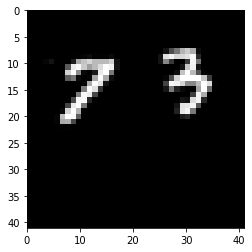

In [114]:
root_path = os.path.dirname(os.getcwd())
file_path = root_path + '/notebooks/data/m-mnist/double-mnist/'
images_path = ['1_01.png', '1_48.png', '1_59.png', '1_62.png', '1_73.png']
images1 = []
for i in range(0, len(images_path)):   
    img = mpimg.imread(file_path + images_path[i])
    img = cv2.resize(img,(40,40))
    images1.append(img)
    H, W = img.shape
    plt.imshow(img, cmap='gray', extent=[0, H+1, W+1, 0])
    
plt.show()

In [115]:
images = np.array([cv2.resize(img, (28, 28)) for img in images1])/255.0
X_test = torch.Tensor(images).float()
print(X_test[0][4,15:22])
test_sample_indices = [0, 1, 2, 3, 4]
a = [[10,13] , [10, 22], [16, 10], [12, 11], [8, 12]]
Y_test = torch.tensor(a)
Y_test
X_test.shape

tensor([0., 0., 0., 0., 0., 0., 0.])


torch.Size([5, 28, 28])

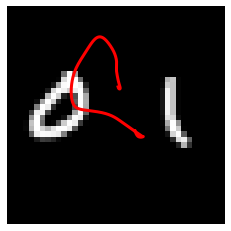

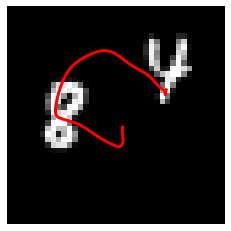

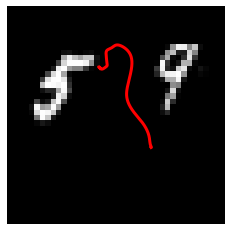

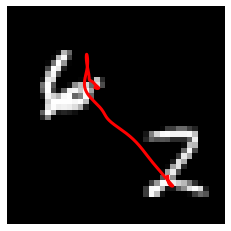

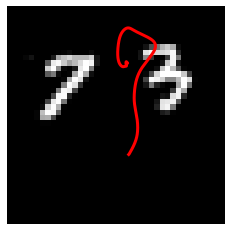

In [116]:
# for DNN-DMP
images2 = np.array([img for img in images1])
X_test2 = torch.Tensor(images2).float()
torch_images = (X_test2[test_sample_indices, :]).float()
# print(torch_images[1][10, 20:35])
torch_predicted_outputs = dnn_dmp_model(torch_images)
torch_predicted_outputs
for i in test_sample_indices:   
    show_DMP_m_mnist(dnn_dmp_model, torch_images, torch_predicted_outputs, i)

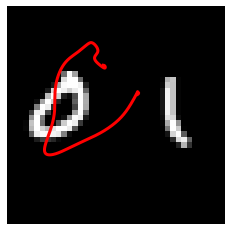

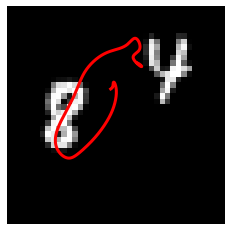

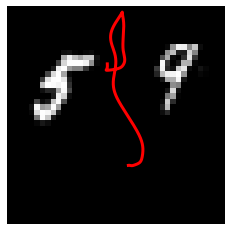

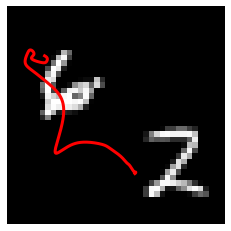

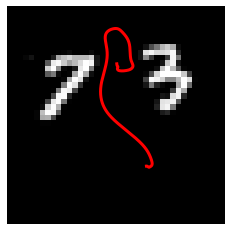

In [117]:
# for CNN-DMP
images2 = np.array([img for img in images1])
X_test2 = torch.Tensor(images2).float()
torch_images = (X_test2[test_sample_indices, :]).float()
torch_predicted_outputs = cnn_dmp_model(torch_images)
torch_predicted_outputs
for i in test_sample_indices:   
    show_DMP_m_mnist(cnn_dmp_model, torch_images, torch_predicted_outputs, i)

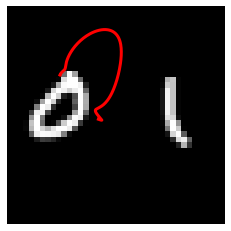

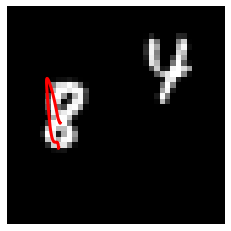

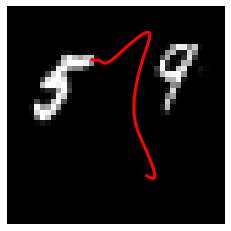

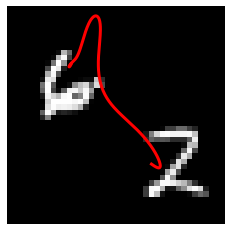

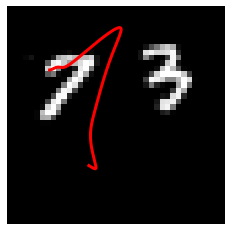

In [118]:
# for DNN-NDP
y_h = dnn_ndp(X_test[test_sample_indices], Y_test)
for i in range(0, len(test_sample_indices)):   
    show_NDP_m_mnist(y_h, images1[test_sample_indices[i]])

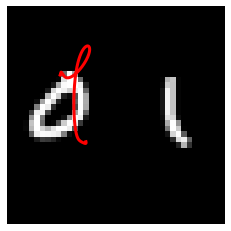

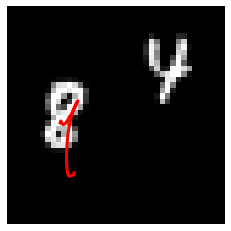

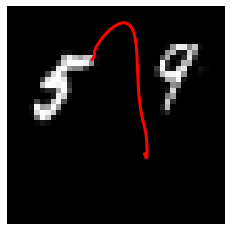

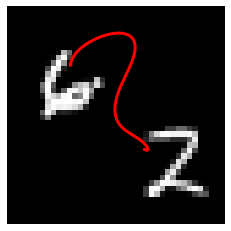

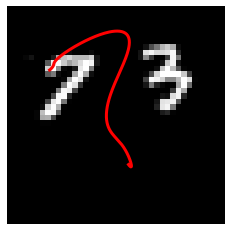

In [119]:
# for SCNN-NDP
y_h = scnn_ndp(X_test[test_sample_indices], Y_test)
for i in range(0, len(test_sample_indices)):   
    show_NDP_m_mnist(y_h, images1[test_sample_indices[i]])

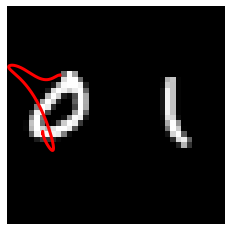

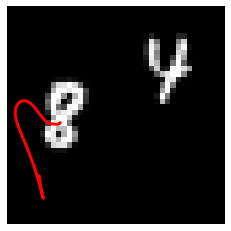

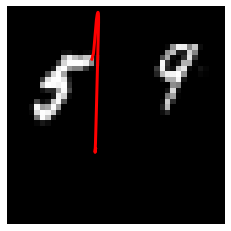

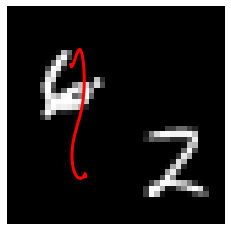

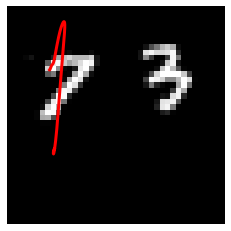

In [120]:
# for CNN-NDP
y_h = cnn_ndp(X_test[test_sample_indices], Y_test)
for i in range(0, len(test_sample_indices)):   
    show_NDP_m_mnist(y_h, images1[test_sample_indices[i]])

### Triple for m-MNIST dataset

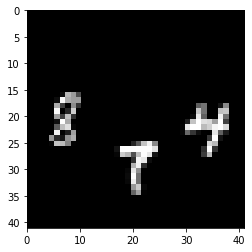

In [147]:
root_path = os.path.dirname(os.getcwd())
file_path = root_path + '/notebooks/data/m-mnist/triple-mnist/'
images_path = ['1_039.png', '1_146.png', '1_258.png', '1_512.png', '1_874.png']
images1 = []
for i in range(0, len(images)):   
    img = mpimg.imread(file_path + images_path[i])
    img = cv2.resize(img,(40,40))
    images1.append(img)
    H, W = img.shape
    plt.imshow(img, cmap='gray', extent=[0, H+1, W+1, 0])
    
plt.show()

In [148]:
images = np.array([cv2.resize(img, (28, 28)) for img in images1])/255
X_test = torch.Tensor(images).float()
# print(X_test[0][:,10:15])
test_sample_indices = [0, 1, 2, 3, 4]
print(images.shape)
a = [[8,22] , [8, 22], [4, 12], [10, 5], [7, 22]]
Y_test = torch.tensor(a)
Y_test

(5, 28, 28)


tensor([[ 8, 22],
        [ 8, 22],
        [ 4, 12],
        [10,  5],
        [ 7, 22]])

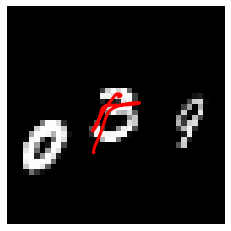

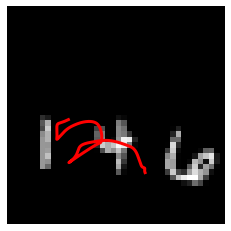

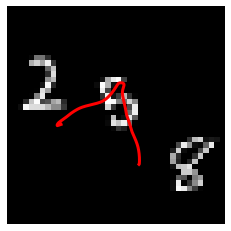

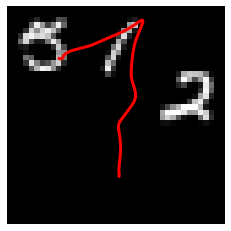

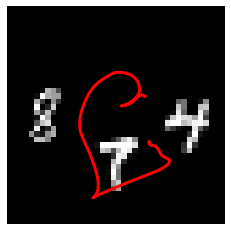

In [149]:
# for DNN-DMP
images2 = np.array([img for img in images1])
X_test2 = torch.Tensor(images2).float()
torch_images = (X_test2[test_sample_indices, :]).float()
# print(torch_images[1][10, 20:35])
torch_predicted_outputs = dnn_dmp_model(torch_images)
torch_predicted_outputs
for i in test_sample_indices:   
    show_DMP_m_mnist(dnn_dmp_model, torch_images, torch_predicted_outputs, i)

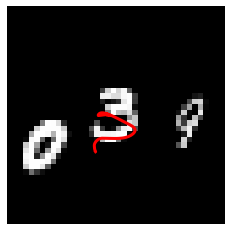

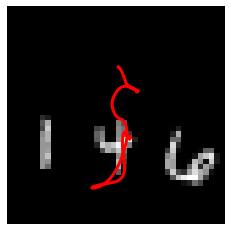

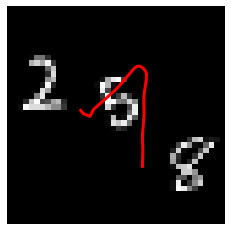

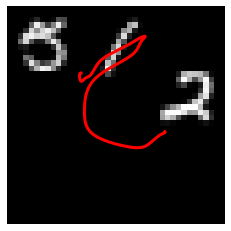

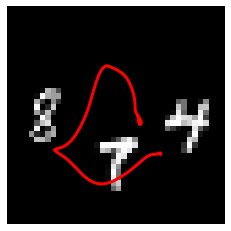

In [150]:
# for CNN-DMP
images2 = np.array([img for img in images1])
X_test2 = torch.Tensor(images2).float()
torch_images = (X_test2[test_sample_indices, :]).float()
torch_predicted_outputs = cnn_dmp_model(torch_images)
torch_predicted_outputs
for i in test_sample_indices:   
    show_DMP_m_mnist(cnn_dmp_model, torch_images, torch_predicted_outputs, i)

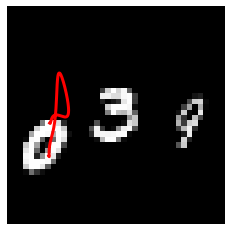

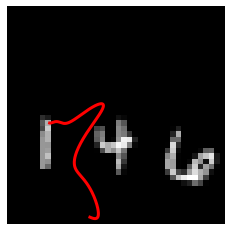

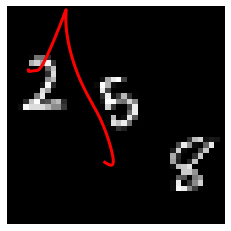

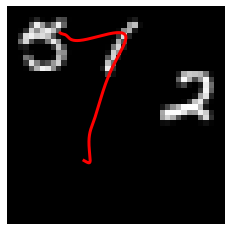

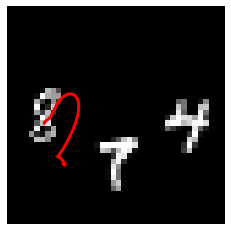

In [151]:
# for DNN-NDP
y_h = dnn_ndp(X_test[test_sample_indices], Y_test)
for i in range(0, len(test_sample_indices)):   
    show_NDP_m_mnist(y_h, images1[test_sample_indices[i]])

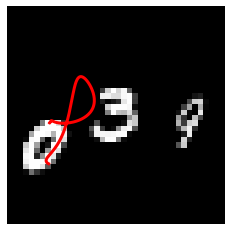

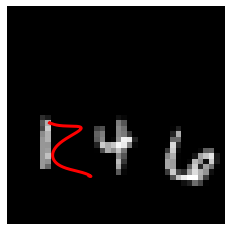

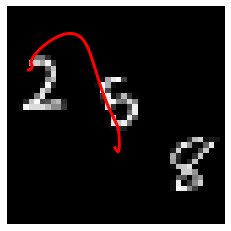

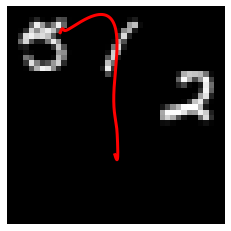

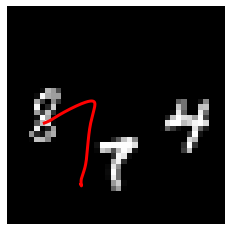

In [152]:
# for SCNN-NDP
y_h = scnn_ndp(X_test[test_sample_indices], Y_test)
for i in range(0, len(test_sample_indices)):   
    show_NDP_m_mnist(y_h, images1[test_sample_indices[i]])

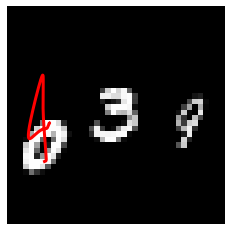

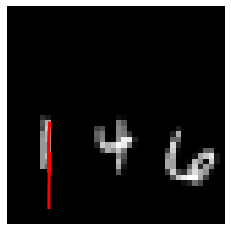

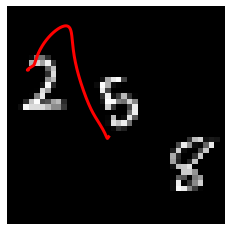

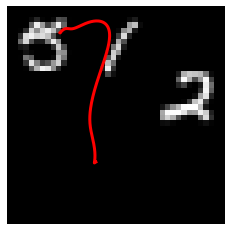

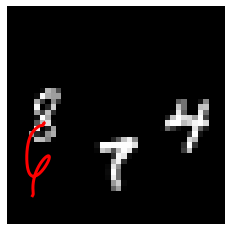

In [153]:
# for CNN-NDP
y_h = cnn_ndp(X_test[test_sample_indices], Y_test)
for i in range(0, len(test_sample_indices)):   
    show_NDP_m_mnist(y_h, images1[test_sample_indices[i]])

## 4, Show the performance of Models on e-MNIST datasets

In [30]:
from emnist import list_datasets

In [31]:
list_datasets()
from emnist import extract_training_samples
from emnist import extract_test_samples
images, labels = extract_training_samples('letters')
print(images.shape)
print(labels.shape)
images, labels = extract_test_samples('letters')
print(images.shape)
print(labels.shape)

(124800, 28, 28)
(124800,)
(20800, 28, 28)
(20800,)


In [32]:
images0 = np.array([cv2.resize(img, (28, 28)) for img in images])/255.0
X_test = torch.Tensor(images0).float() /1000.0
# Y_test = torch.Tensor(np.array(or_tr)[:, :, :2]).float()
test_sample_indices = [381,2029,3270, 1068,6292, 8353, 1405, 18144, 9218, 20698, 4852, 6665, 20447,13588, 5402, 16128]
X_test.shape
a = [[10,24], [28,18],[38, 7], [26, 8], [16, 12], 
     [10,10], [16,8], [4,8], [30,8] , [5, 8], 
     [30, 13], [26, 8], [3, 13], [20,8], [25, 13], [15, 8]]
Y_test = torch.tensor(a)
# Y_test

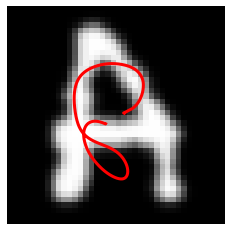

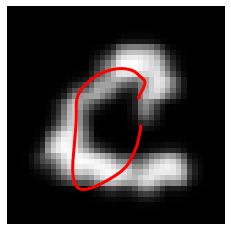

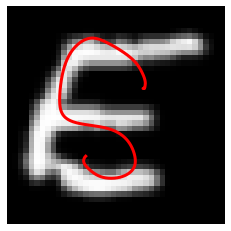

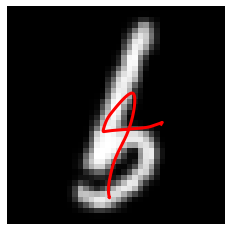

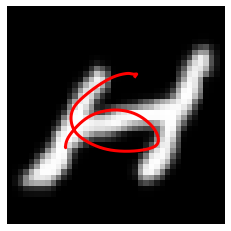

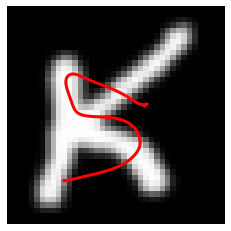

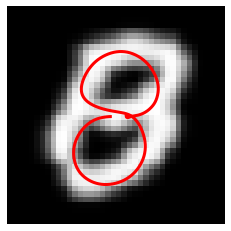

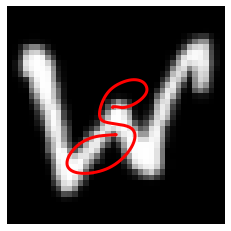

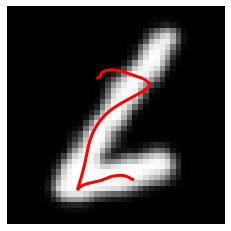

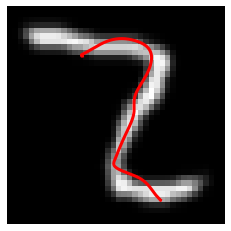

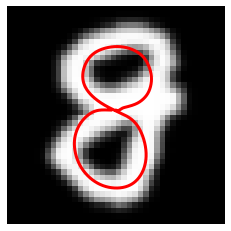

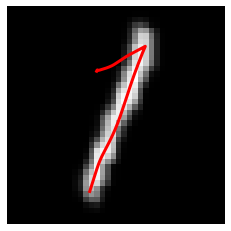

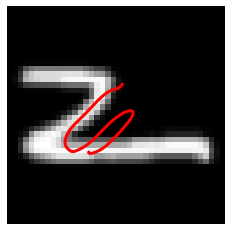

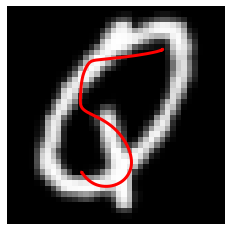

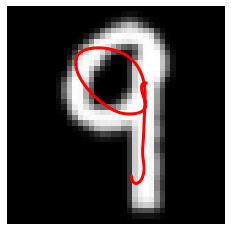

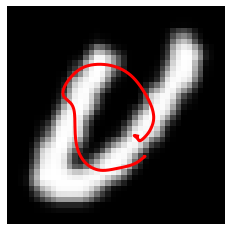

In [33]:
# for DNN-DMP
images1 = np.array([cv2.resize(img, (40, 40)) for img in images]) / 255.0
images2 = np.array([img for img in images1])
X_test2 = torch.Tensor(images2).float()
torch_images = (X_test2[test_sample_indices, :]).float()
# print(torch_images[1][10, 20:35])
torch_predicted_outputs = dnn_dmp_model(torch_images)
torch_predicted_outputs
for i in range(0, len(test_sample_indices)):   
    show_DMP_m_mnist(dnn_dmp_model, torch_images, torch_predicted_outputs, i)

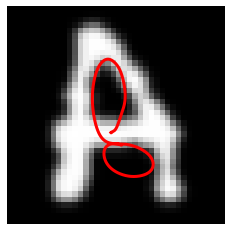

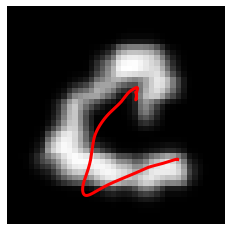

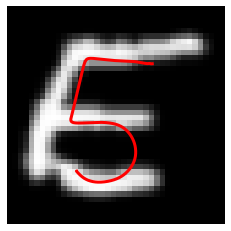

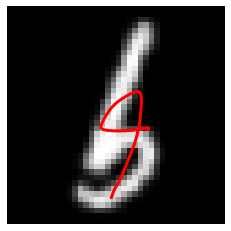

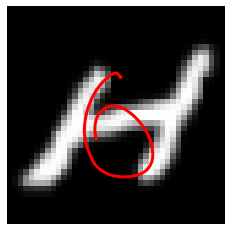

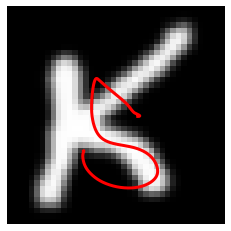

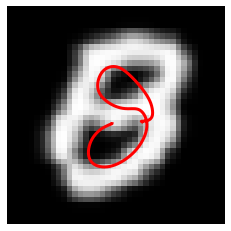

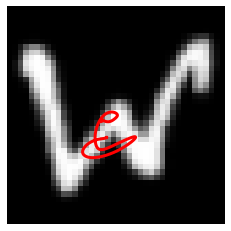

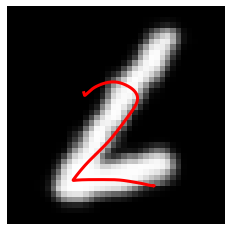

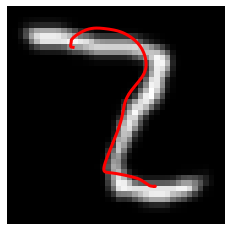

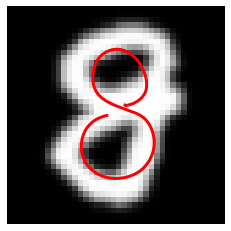

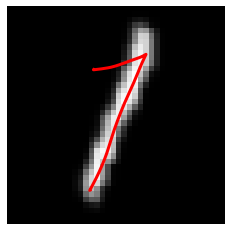

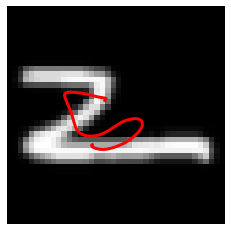

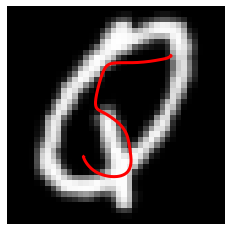

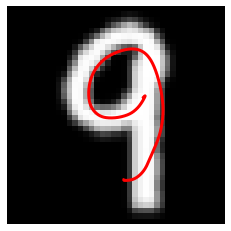

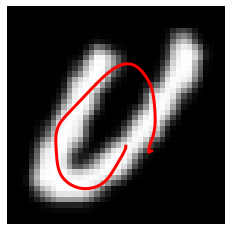

In [34]:
# for CNN-DMP
images1 = np.array([cv2.resize(img, (40, 40)) for img in images]) / 255.0
images2 = np.array([img for img in images1])
X_test2 = torch.Tensor(images2).float()
torch_images = (X_test2[test_sample_indices, :]).float()
# print(torch_images[1][10, 20:35])
torch_predicted_outputs = cnn_dmp_model(torch_images)
torch_predicted_outputs
for i in range(0, len(test_sample_indices)): 
    show_DMP_m_mnist(cnn_dmp_model, torch_images, torch_predicted_outputs, i)

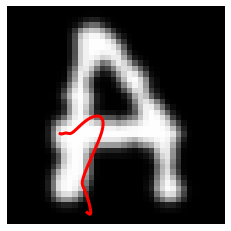

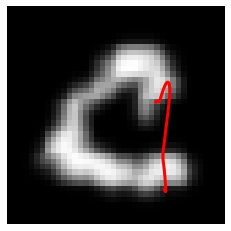

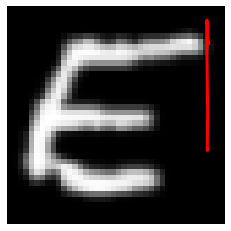

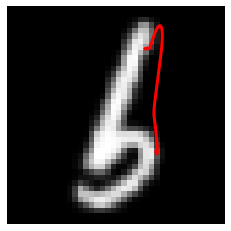

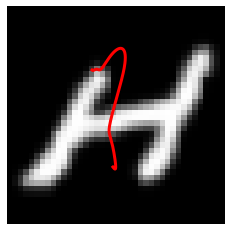

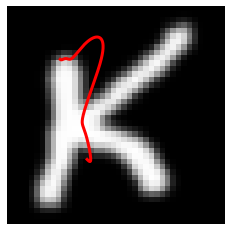

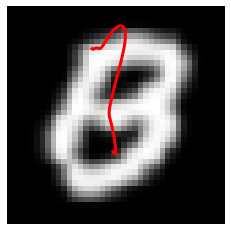

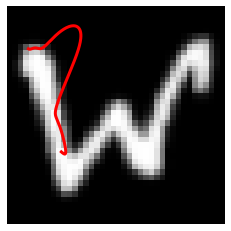

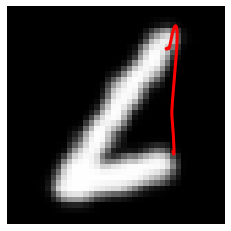

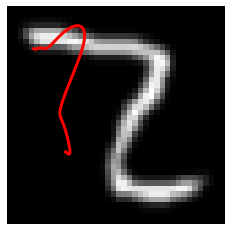

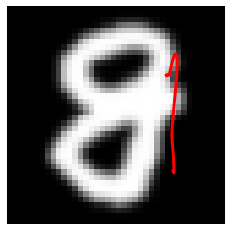

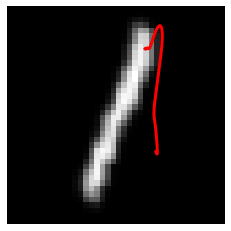

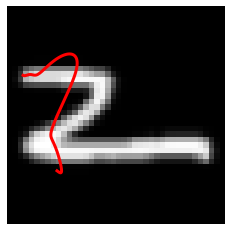

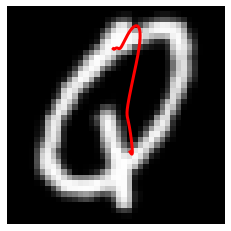

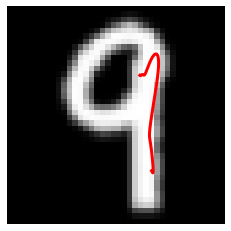

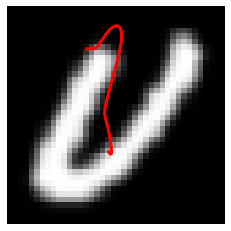

In [35]:
# for DNN-NDP
X_test = X_test / 1000.0
images1 = np.array([cv2.resize(img, (40, 40)) for img in images]) / 255.0
y_h = dnn_ndp(X_test[test_sample_indices], Y_test)
for i in range(0, len(test_sample_indices)):   
    show_NDP_m_mnist(y_h, images1[test_sample_indices[i]])

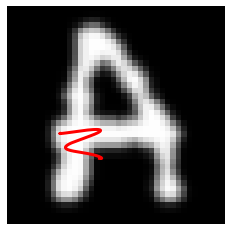

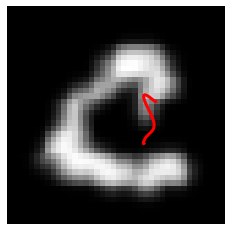

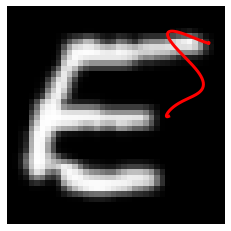

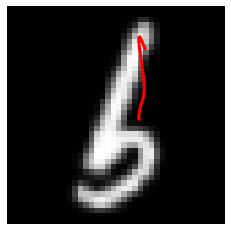

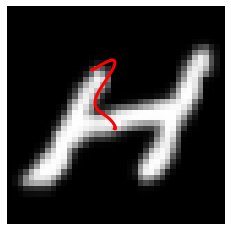

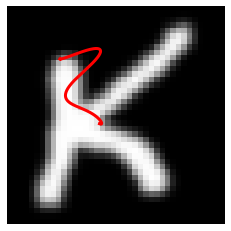

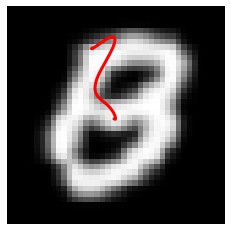

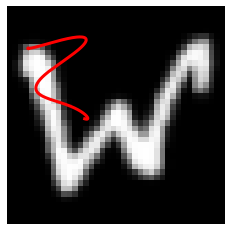

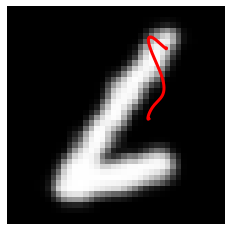

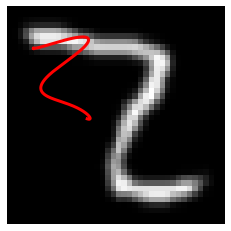

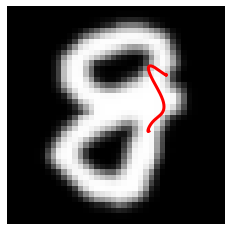

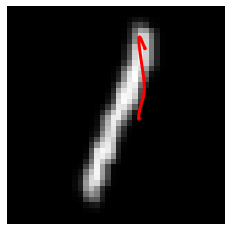

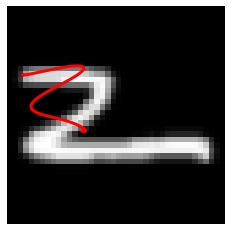

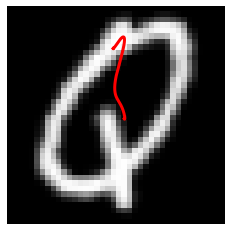

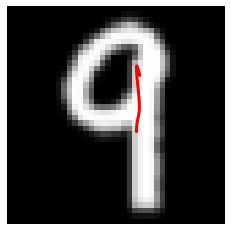

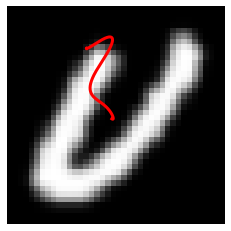

In [36]:
# for SCNN-NDP
images1 = np.array([cv2.resize(img, (40, 40)) for img in images]) / 255.0
y_h = scnn_ndp(X_test[test_sample_indices], Y_test)
for i in range(0, len(test_sample_indices)):   
    show_NDP_m_mnist(y_h, images1[test_sample_indices[i]])

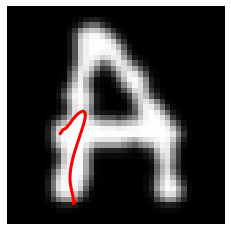

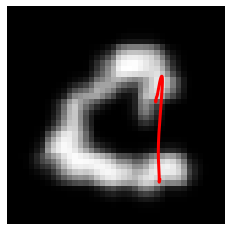

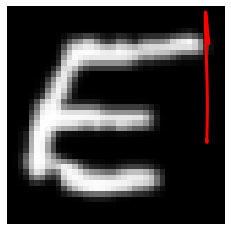

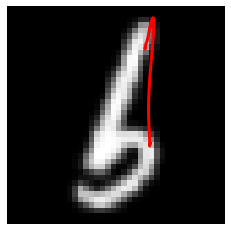

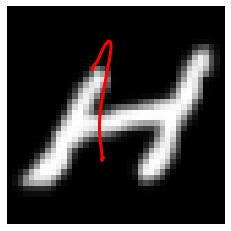

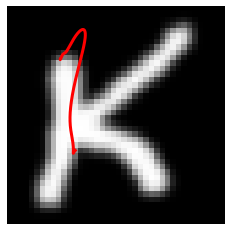

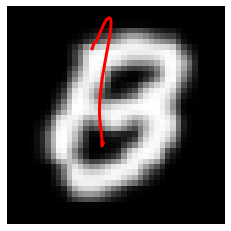

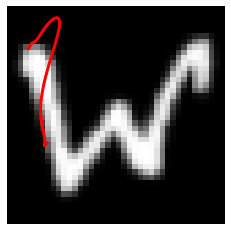

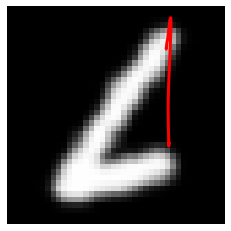

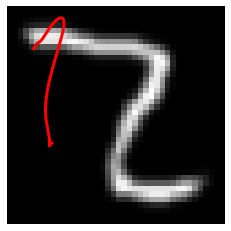

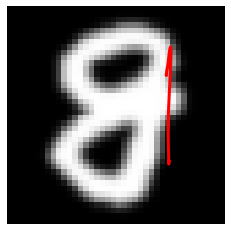

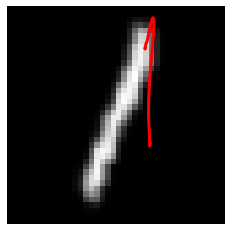

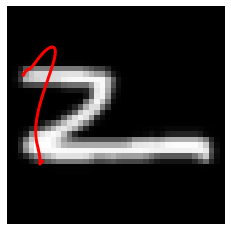

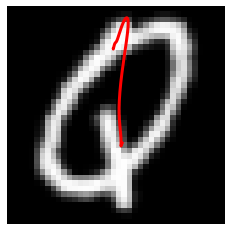

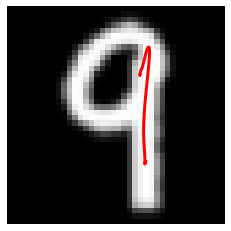

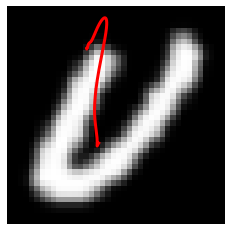

In [37]:
# for CNN-NDP
X_test = X_test / 1000
images1 = np.array([cv2.resize(img, (40, 40)) for img in images]) / 255.0
y_h = cnn_ndp(X_test[test_sample_indices], Y_test)
for i in range(0, len(test_sample_indices)):   
    show_NDP_m_mnist(y_h, images1[test_sample_indices[i]])